In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})  # enlarge matplotlib fonts

# Import qubit states Zero (|0>) and One (|1>), and Pauli operators (X, Y, Z)
from qiskit.opflow import Zero, One, I, X, Y, Z

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importing standard Qiskit modules
from qiskit import QuantumCircuit, QuantumRegister, IBMQ, execute, transpile
from qiskit.providers.aer import QasmSimulator
from qiskit.tools.monitor import job_monitor
from qiskit.circuit import Parameter, ParameterVector

# Import state tomography modules
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
from qiskit.quantum_info import state_fidelity

# Import optimizer to optimize the variational cirucit
from qiskit.aqua.components.optimizers import COBYLA

from qiskit import Aer

from qiskit.providers.aer import StatevectorSimulator


In [3]:
provider = IBMQ.load_account()

In [4]:
provider = IBMQ.get_provider(hub='ibm-q-community', group='ibmquantumawards', project='open-science-22')
jakarta = provider.get_backend('ibmq_jakarta')

# properties = jakarta.properties()

# Simulated backend based on ibmq_jakarta's device noise profile
sim_noisy_jakarta = QasmSimulator.from_backend(provider.get_backend('ibmq_jakarta'))

# Noiseless simulated backend
sim = QasmSimulator()


## Make the compressed XYZ gate a variational gate

In [12]:
# This is the compressed variational XYZ gate
def R_xyz_variational(theta):
    
    t_qr = QuantumRegister(2)
    t_qc = QuantumCircuit(t_qr, name='XYZ')
    
    t_qc.cnot(0,1)
    t_qc.rx(2*theta-np.pi/2, 0)
    t_qc.rz(2 * theta, 1)
    t_qc.h(0)
    t_qc.cnot(0,1)
    t_qc.h(0)
    t_qc.rz(-2 * theta, 1)
    t_qc.cnot(0,1)
    t_qc.rx(np.pi/2,0)
    t_qc.rx(-np.pi/2,1)

    return t_qc

In [13]:
theta = ParameterVector('theta', 5)

In [14]:
# We use "randomization", i.e. change the order of the sum over qubits at every Trotter layer
# we see that this way the same gate with the same angle is repeated, we can thus combine the gates with double the variational parameter

num_qubits = 3

Trot_qr = QuantumRegister(num_qubits)
Trot_qc = QuantumCircuit(Trot_qr, name='Trot')

Trot_qc.append(R_xyz_variational(theta[0]).to_instruction(), [Trot_qr[1], Trot_qr[2]])
Trot_qc.append(R_xyz_variational(2 * theta[1]).to_instruction(), [Trot_qr[0], Trot_qr[1]])
Trot_qc.append(R_xyz_variational(2 * theta[2]).to_instruction(), [Trot_qr[1], Trot_qr[2]])
Trot_qc.append(R_xyz_variational(2 * theta[3]).to_instruction(), [Trot_qr[0], Trot_qr[1]])
Trot_qc.append(R_xyz_variational(theta[4]).to_instruction(), [Trot_qr[1], Trot_qr[2]])

# Convert custom quantum circuit into a gate
Trot_gate = Trot_qc.to_instruction()

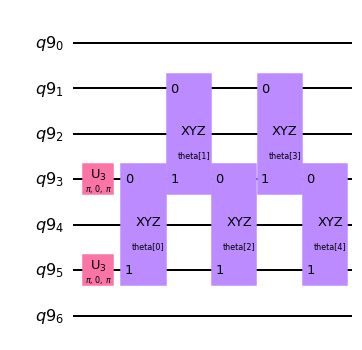

In [15]:
# The final time of the state evolution
# target_time = np.pi

# Number of trotter steps
trotter_steps = 4  ### CAN BE >= 4

# Initialize quantum circuit for 3 qubits
qr = QuantumRegister(7)
qc = QuantumCircuit(qr)

# Prepare initial state (remember we are only evolving 3 of the 7 qubits on jakarta qubits (q_5, q_3, q_1) corresponding to the state |110>)
qc.x([3,5])  # DO NOT MODIFY (|q_5,q_3,q_1> = |110>)

# Simulate time evolution under H_heis3 Hamiltonian
## Standard and alternative 1

#for _ in range(trotter_steps):
#    qc.append(Trot_gate, [qr[1], qr[3], qr[5]])
    
## Alternative 2
qc.append(Trot_gate, [qr[1], qr[3], qr[5]])

# Evaluate simulation at target_time (t=pi) meaning each trotter step evolves pi/trotter_steps in time
#qc = qc.bind_parameters({t: target_time/trotter_steps})

qc.decompose().draw(output="mpl")  # view decomposition of trotter gates

In [16]:
def get_var_form(theta):
    qr = QuantumRegister(7)
    qc = QuantumCircuit(qr)
    qc.x([3,5])

    Trot_qr = QuantumRegister(num_qubits)
    Trot_qc = QuantumCircuit(Trot_qr, name='Trot')

    Trot_qc.append(R_xyz_variational(theta[0]).to_instruction(), [Trot_qr[1], Trot_qr[2]])
    Trot_qc.append(R_xyz_variational(2 * theta[1]).to_instruction(), [Trot_qr[0], Trot_qr[1]])
    Trot_qc.append(R_xyz_variational(2 * theta[2]).to_instruction(), [Trot_qr[1], Trot_qr[2]])
    Trot_qc.append(R_xyz_variational(2 * theta[3]).to_instruction(), [Trot_qr[0], Trot_qr[1]])
    Trot_qc.append(R_xyz_variational(theta[4]).to_instruction(), [Trot_qr[1], Trot_qr[2]])
    
    Trot_gate = Trot_qc.to_instruction()
    qc.append(Trot_gate, [qr[1], qr[3], qr[5]])
    # qc.measure(qr, [qr[1], qr[3], qr[5]])
    return qc, qr

In [17]:
def objective_function(params):

    # TODO: Put Stefano's algorithm here

    backend = Aer.get_backend('statevector_simulator')

    qr = QuantumRegister(7)
    qc = QuantumCircuit(qr)
    qc.x([3,5])
    result = execute(qc, backend).result()
    target_state = result.get_statevector(qc) 

    qc, _ = get_var_form(theta)
    qc = qc.bind_parameters({theta: params})

    result = execute(qc, backend).result()
    state = result.get_statevector(qc)
    cost = 1 - state_fidelity(target_state, state)
    
    return cost

In [37]:
# Optimize the circuit parameters
optimizer = COBYLA(maxiter=500, tol=0.0001)
#params = np.random.rand(5)
#params = np.zeros(5)

params = (np.pi/4)*np.ones(5)
ret = optimizer.optimize(num_vars=5, objective_function=objective_function, initial_point=params)

In [38]:
ret

(array([1.91039816, 0.78533428, 0.91039816, 0.78532123, 0.78539816]),
 2.811259607327088e-07,
 50)

In [39]:
# Check fidelity using full state tomography
qc, qr = get_var_form(theta)
qc = qc.bind_parameters({theta: ret[0]})
#qc = qc.bind_parameters({theta2: np.zeros(5)})
st_qcs = state_tomography_circuits(qc, [qr[1], qr[3], qr[5]])

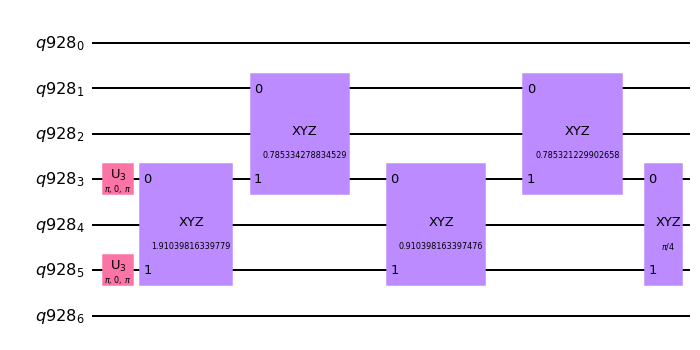

In [24]:
qc.decompose().draw(output="mpl") 

In [25]:
shots = 8192
reps = 1
backend = sim_noisy_jakarta
# backend = Aer.get_backend('aer_simulator_statevector')
# reps = 8
#backend = jakarta

jobs = []
for _ in range(reps):
    # execute
    job = execute(st_qcs, backend, optimization_level=3, shots=shots)
    print('Job ID', job.job_id())
    jobs.append(job)

Job ID b9599db4-7284-4ac2-a37a-313258bc62c7


In [26]:
# Compute the state tomography based on the st_qcs quantum circuits and the results from those ciricuits
def state_tomo(result, st_qcs):
    # The expected final state; necessary to determine state tomography fidelity
    target_state = (One^One^Zero).to_matrix()  # DO NOT MODIFY (|q_5,q_3,q_1> = |110>)
    # Fit state tomography results
    tomo_fitter = StateTomographyFitter(result, st_qcs)
    rho_fit = tomo_fitter.fit(method='lstsq')
    # Compute fidelity
    fid = state_fidelity(rho_fit, target_state)
    return fid

# Compute tomography fidelities for each repetition
fids = []
for job in jobs:
    fid = state_tomo(job.result(), st_qcs)
    fids.append(fid)
    
print('state tomography fidelity = {:.4f} \u00B1 {:.4f}'.format(np.mean(fids), np.std(fids)))

state tomography fidelity = 0.6893 ± 0.0000


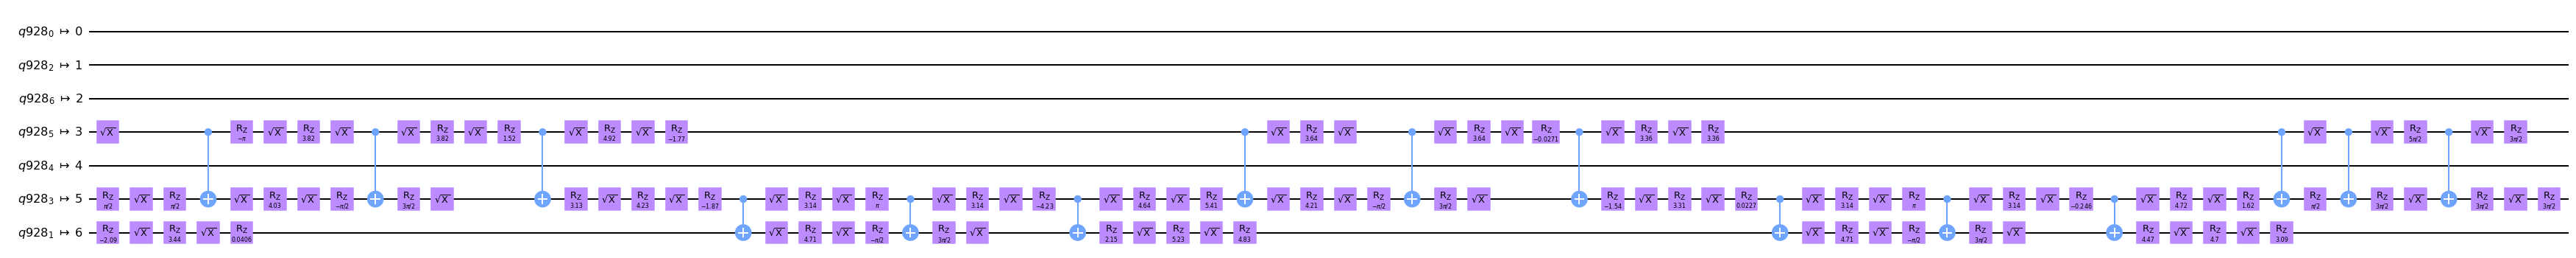

In [27]:
transpiled_qc = transpile(qc, optimization_level=3, backend=jakarta)
transpiled_qc.draw(output="mpl",fold=-1)

In [28]:
print('depth: {}, #cx: {}, #sx: {}'.format(transpiled_qc.depth(), transpiled_qc.count_ops()['cx'], transpiled_qc.count_ops()['sx']))

depth: 74, #cx: 15, #sx: 53


## Let's become ambitous and play around with error mitigation!

In [29]:
from mitiq.zne.inference import LinearFactory, RichardsonFactory, PolyFactory
from mitiq.zne.zne import execute_with_zne

In [60]:
# Function that does state tomography with circ and return the fideltiy
# To be used in the error mitigation (mitq)
def executor(circ):
    
    # Setting all the parameters that are need
    shots = 8192
    backend = sim_noisy_jakarta
    
    # Create list of state tomography circuits out of circ
    st_qcs = state_tomography_circuits(circ, [qr[1], qr[3], qr[5]])

    # Execute the state tomography circuits (maybe wrap into separate function)
    reps = 1
    jobs = []
    for _ in range(reps):

        job = execute(st_qcs, backend, optimization_level=0, shots=shots)
        print('Job ID', job.job_id())
        jobs.append(job)

    # Compute tomography fidelities for each repetition (maybe wrap into separate function)
    fids = []
    for job in jobs:
        fid = state_tomo(job.result(), st_qcs)
        fids.append(fid)
    
    return np.mean(fids)

In [61]:
executor(qc)

Job ID 450929b5-23a2-49d8-95e8-df2cc9db0186


0.5780272259720511

In [62]:
# method: scale noise by 1 and 2, then extrapolate linearly to the zero noise limit.
linear_fac = LinearFactory(scale_factors=[1.0, 2.0])

# method: scale noise by 1, 2 and 3, then evaluate the Richardson extrapolation.
richardson_fac = RichardsonFactory(scale_factors=[1.0, 2.0, 3.0])

# method: scale noise by 1, 2, 3, and 4, then extrapolate quadratically to the zero noise limit.
poly_fac = PolyFactory(scale_factors=[1.0, 2.0, 3.0, 4.0], order=2)

In [63]:
from qiskit.quantum_info import Operator
tmp = Operator(qc)

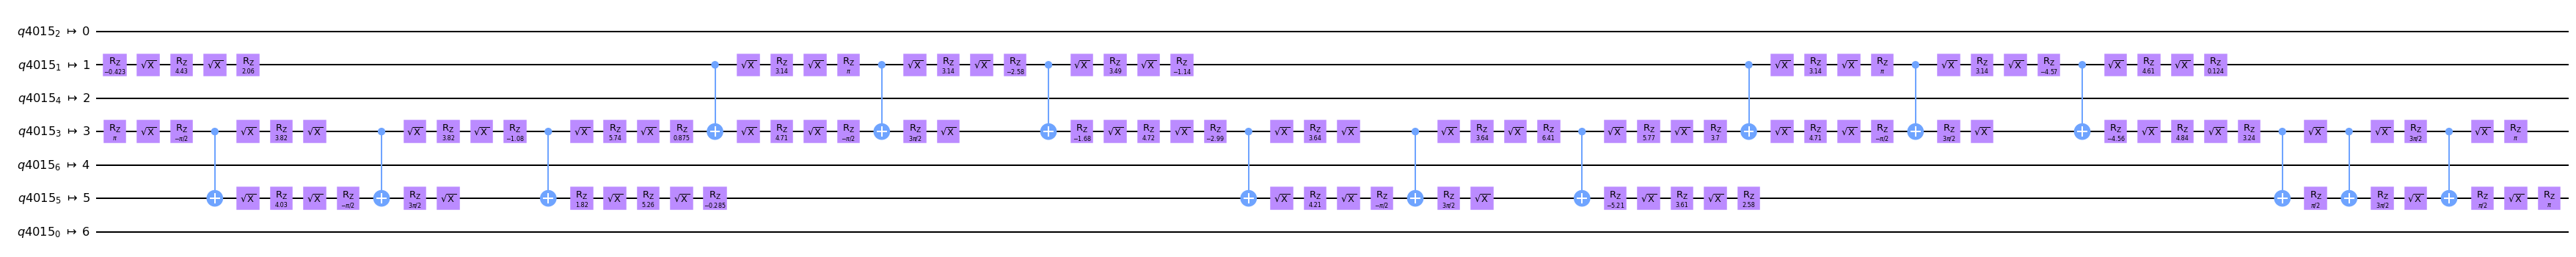

In [64]:
transpiled_qc = transpile(qc, optimization_level=3, backend=jakarta)
transpiled_qc.draw(output="mpl",fold=-1)

In [65]:
from mitiq.zne.scaling import fold_gates_from_right

In [70]:
qr = QuantumRegister(7)
qc = QuantumCircuit(qr)

qc.sx([3,5])  

In [71]:
folded = fold_gates_from_right(qc, scale_factor=2.)

CircuitConversionError: Circuit could not be converted to an internal Mitiq circuit. This may be because the circuit contains custom gates or Pragmas (pyQuil). If you think this is a bug or that this circuit should be supported, you can open an issue at https://github.com/unitaryfund/mitiq. 

Provided circuit has type <class 'qiskit.circuit.quantumcircuit.QuantumCircuit'> and is:

               
q8845_0: ──────
               
q8845_1: ──────
               
q8845_2: ──────
         ┌────┐
q8845_3: ┤ √X ├
         └────┘
q8845_4: ──────
         ┌────┐
q8845_5: ┤ √X ├
         └────┘
q8845_6: ──────
               

Circuit types supported by Mitiq are 
{'cirq': 'Circuit', 'pyquil': 'Program', 'qiskit': 'QuantumCircuit', 'braket': 'Circuit', 'pennylane': 'QuantumTape'}.

In [52]:
zne_expval = execute_with_zne(transpiled_qc, executor, factory=linear_fac)
print(f"Error with linear_fac: {abs(1 - zne_expval):.4f}")

#zne_expval = execute_with_zne(qc, objective_function, factory=richardson_fac)
#print(f"Error with richardson_fac: {abs(1 - zne_expval):.4f}")

#zne_expval = execute_with_zne(qc, objective_function, factory=poly_fac)
#print(f"Error with poly_fac: {abs(1 - zne_expval):.4f}")

CircuitConversionError: Circuit could not be converted to an internal Mitiq circuit. This may be because the circuit contains custom gates or Pragmas (pyQuil). If you think this is a bug or that this circuit should be supported, you can open an issue at https://github.com/unitaryfund/mitiq. 

Provided circuit has type <class 'qiskit.circuit.quantumcircuit.QuantumCircuit'> and is:

                                                                        »
q4015_0 -> 0 ───────────────────────────────────────────────────────────»
               ┌──────────┐ ┌────┐                            ┌────┐    »
q4015_3 -> 1 ──┤ RZ(3π/2) ├─┤ √X ├─────────────────────■──────┤ √X ├────»
             ┌─┴──────────┴┐├────┤┌───────────┐┌────┐  │  ┌───┴────┴───┐»
q4015_1 -> 2 ┤ RZ(-1.2373) ├┤ √X ├┤ RZ(5.681) ├┤ √X ├──┼──┤ RZ(1.0064) ├»
             └──┬───────┬──┘├────┤└┬──────────┤└────┘┌─┴─┐└───┬────┬───┘»
q4015_5 -> 3 ───┤ RZ(π) ├───┤ √X ├─┤ RZ(3π/2) ├──────┤ X ├────┤ √X ├────»
                └───────┘   └────┘ └──────────┘      └───┘    └────┘    »
q4015_2 -> 4 ───────────────────────────────────────────────────────────»
                                                                        »
q4015_4 -> 5 ───────────────────────────────────────────────────────────»
                                                                        »
q4015_6 -> 6 ───────────────────────────────────────────────────────────»
                                                                        »
«                                                                            »
«q4015_0 -> 0 ───────────────────────────────────────────────────────────────»
«             ┌────────────┐┌────┐                    ┌────┐   ┌────────────┐»
«q4015_3 -> 1 ┤ RZ(3.8208) ├┤ √X ├──────────────■─────┤ √X ├───┤ RZ(3.8208) ├»
«             └────────────┘└────┘              │     └────┘   └────────────┘»
«q4015_1 -> 2 ──────────────────────────────────┼────────────────────────────»
«             ┌────────────┐┌────┐┌──────────┐┌─┴─┐┌──────────┐    ┌────┐    »
«q4015_5 -> 3 ┤ RZ(4.0332) ├┤ √X ├┤ RZ(-π/2) ├┤ X ├┤ RZ(3π/2) ├────┤ √X ├────»
«             └────────────┘└────┘└──────────┘└───┘└──────────┘    └────┘    »
«q4015_2 -> 4 ───────────────────────────────────────────────────────────────»
«                                                                            »
«q4015_4 -> 5 ───────────────────────────────────────────────────────────────»
«                                                                            »
«q4015_6 -> 6 ───────────────────────────────────────────────────────────────»
«                                                                            »
«                                                                    »
«q4015_0 -> 0 ───────────────────────────────────────────────────────»
«             ┌────┐┌─────────────┐          ┌────┐    ┌────────────┐»
«q4015_3 -> 1 ┤ √X ├┤ RZ(-2.3518) ├──■───────┤ √X ├────┤ RZ(5.5356) ├»
«             └────┘└─────────────┘  │       └────┘    └────────────┘»
«q4015_1 -> 2 ───────────────────────┼───────────────────────────────»
«                                  ┌─┴─┐┌─────────────┐    ┌────┐    »
«q4015_5 -> 3 ─────────────────────┤ X ├┤ RZ(-1.1899) ├────┤ √X ├────»
«                                  └───┘└─────────────┘    └────┘    »
«q4015_2 -> 4 ───────────────────────────────────────────────────────»
«                                                                    »
«q4015_4 -> 5 ───────────────────────────────────────────────────────»
«                                                                    »
«q4015_6 -> 6 ───────────────────────────────────────────────────────»
«                                                                    »
«                                                                          »
«q4015_0 -> 0 ─────────────────────────────────────────────────────────────»
«                 ┌────┐   ┌────────────┐              ┌────┐┌────────────┐»
«q4015_3 -> 1 ────┤ √X ├───┤ RZ(1.2945) ├──────■───────┤ √X ├┤ RZ(3.1418) ├»
«                 └────┘   └────────────┘    ┌─┴─┐     ├────┤├────────────┤»
«q4015_1 -> 2 ───────────────────────────────┤ X ├─────┤ √X ├┤ RZ(4.7121) ├»
«             ┌───────────┐    ┌────┐    ┌───┴───┴────┐└────┘└────────────┘»
«q4015_5 -> 3 ┤ RZ(4.354) ├────┤ √X ├────┤ RZ(4.8837) ├────────────────────»
«             └───────────┘    └────┘    └────────────┘                    »
«q4015_2 -> 4 ─────────────────────────────────────────────────────────────»
«                                                                          »
«q4015_4 -> 5 ─────────────────────────────────────────────────────────────»
«                                                                          »
«q4015_6 -> 6 ─────────────────────────────────────────────────────────────»
«                                                                          »
«                                                                    »
«q4015_0 -> 0 ───────────────────────────────────────────────────────»
«             ┌────┐ ┌───────┐          ┌────┐   ┌────────────┐┌────┐»
«q4015_3 -> 1 ┤ √X ├─┤ RZ(π) ├────■─────┤ √X ├───┤ RZ(3.1418) ├┤ √X ├»
«             ├────┤┌┴───────┴─┐┌─┴─┐┌──┴────┴──┐└───┬────┬───┘└────┘»
«q4015_1 -> 2 ┤ √X ├┤ RZ(-π/2) ├┤ X ├┤ RZ(3π/2) ├────┤ √X ├──────────»
«             └────┘└──────────┘└───┘└──────────┘    └────┘          »
«q4015_5 -> 3 ───────────────────────────────────────────────────────»
«                                                                    »
«q4015_2 -> 4 ───────────────────────────────────────────────────────»
«                                                                    »
«q4015_4 -> 5 ───────────────────────────────────────────────────────»
«                                                                    »
«q4015_6 -> 6 ───────────────────────────────────────────────────────»
«                                                                    »
«                                                                            »
«q4015_0 -> 0 ───────────────────────────────────────────────────────────────»
«             ┌─────────────┐          ┌────┐    ┌────────────┐    ┌────┐    »
«q4015_3 -> 1 ┤ RZ(0.83831) ├──■───────┤ √X ├────┤ RZ(5.4766) ├────┤ √X ├────»
«             └─────────────┘┌─┴─┐┌────┴────┴───┐└───┬────┬───┘┌───┴────┴───┐»
«q4015_1 -> 2 ───────────────┤ X ├┤ RZ(-2.1798) ├────┤ √X ├────┤ RZ(4.9873) ├»
«                            └───┘└─────────────┘    └────┘    └────────────┘»
«q4015_5 -> 3 ───────────────────────────────────────────────────────────────»
«                                                                            »
«q4015_2 -> 4 ───────────────────────────────────────────────────────────────»
«                                                                            »
«q4015_4 -> 5 ───────────────────────────────────────────────────────────────»
«                                                                            »
«q4015_6 -> 6 ───────────────────────────────────────────────────────────────»
«                                                                            »
«                                                                          »
«q4015_0 -> 0 ─────────────────────────────────────────────────────────────»
«             ┌─────────────┐                    ┌────┐┌────────────┐┌────┐»
«q4015_3 -> 1 ┤ RZ(-0.7957) ├─────────────────■──┤ √X ├┤ RZ(3.6416) ├┤ √X ├»
«             └────┬────┬───┘┌─────────────┐  │  └────┘└────────────┘└────┘»
«q4015_1 -> 2 ─────┤ √X ├────┤ RZ(0.55109) ├──┼────────────────────────────»
«                  └────┘    └─────────────┘┌─┴─┐┌────┐┌────────────┐┌────┐»
«q4015_5 -> 3 ──────────────────────────────┤ X ├┤ √X ├┤ RZ(4.2124) ├┤ √X ├»
«                                           └───┘└────┘└────────────┘└────┘»
«q4015_2 -> 4 ─────────────────────────────────────────────────────────────»
«                                                                          »
«q4015_4 -> 5 ─────────────────────────────────────────────────────────────»
«                                                                          »
«q4015_6 -> 6 ─────────────────────────────────────────────────────────────»
«                                                                          »
«                                                                            »
«q4015_0 -> 0 ───────────────────────────────────────────────────────────────»
«                                 ┌────┐   ┌────────────┐┌────┐┌────────────┐»
«q4015_3 -> 1 ──────────────■─────┤ √X ├───┤ RZ(3.6416) ├┤ √X ├┤ RZ(5.6615) ├»
«                           │     └────┘   └────────────┘└────┘└────────────┘»
«q4015_1 -> 2 ──────────────┼────────────────────────────────────────────────»
«             ┌──────────┐┌─┴─┐┌──────────┐    ┌────┐                        »
«q4015_5 -> 3 ┤ RZ(-π/2) ├┤ X ├┤ RZ(3π/2) ├────┤ √X ├────────────────────────»
«             └──────────┘└───┘└──────────┘    └────┘                        »
«q4015_2 -> 4 ───────────────────────────────────────────────────────────────»
«                                                                            »
«q4015_4 -> 5 ───────────────────────────────────────────────────────────────»
«                                                                            »
«q4015_6 -> 6 ───────────────────────────────────────────────────────────────»
«                                                                            »
«                                                                           »
«q4015_0 -> 0 ──────────────────────────────────────────────────────────────»
«                       ┌────┐    ┌────────────┐    ┌────┐    ┌────────────┐»
«q4015_3 -> 1 ──■───────┤ √X ├────┤ RZ(3.3799) ├────┤ √X ├────┤ RZ(1.1231) ├»
«               │       └────┘    └────────────┘    └────┘    └────────────┘»
«q4015_1 -> 2 ──┼───────────────────────────────────────────────────────────»
«             ┌─┴─┐┌─────────────┐    ┌────┐    ┌────────────┐    ┌────┐    »
«q4015_5 -> 3 ┤ X ├┤ RZ(-3.5933) ├────┤ √X ├────┤ RZ(4.9728) ├────┤ √X ├────»
«             └───┘└─────────────┘    └────┘    └────────────┘    └────┘    »
«q4015_2 -> 4 ──────────────────────────────────────────────────────────────»
«                                                                           »
«q4015_4 -> 5 ──────────────────────────────────────────────────────────────»
«                                                                           »
«q4015_6 -> 6 ──────────────────────────────────────────────────────────────»
«                                                                           »
«                                                                      »
«q4015_0 -> 0 ─────────────────────────────────────────────────────────»
«                           ┌────┐┌────────────┐┌────┐ ┌───────┐       »
«q4015_3 -> 1 ──────■───────┤ √X ├┤ RZ(3.1419) ├┤ √X ├─┤ RZ(π) ├────■──»
«                 ┌─┴─┐     ├────┤├────────────┤├────┤┌┴───────┴─┐┌─┴─┐»
«q4015_1 -> 2 ────┤ X ├─────┤ √X ├┤ RZ(4.7121) ├┤ √X ├┤ RZ(-π/2) ├┤ X ├»
«             ┌───┴───┴────┐└────┘└────────────┘└────┘└──────────┘└───┘»
«q4015_5 -> 3 ┤ RZ(2.8403) ├───────────────────────────────────────────»
«             └────────────┘                                           »
«q4015_2 -> 4 ─────────────────────────────────────────────────────────»
«                                                                      »
«q4015_4 -> 5 ─────────────────────────────────────────────────────────»
«                                                                      »
«q4015_6 -> 6 ─────────────────────────────────────────────────────────»
«                                                                      »
«                                                                              »
«q4015_0 -> 0 ─────────────────────────────────────────────────────────────────»
«                ┌────┐   ┌────────────┐┌────┐┌────────────┐         ┌────┐    »
«q4015_3 -> 1 ───┤ √X ├───┤ RZ(3.1419) ├┤ √X ├┤ RZ(1.3964) ├──■──────┤ √X ├────»
«             ┌──┴────┴──┐└───┬────┬───┘└────┘└────────────┘┌─┴─┐┌───┴────┴───┐»
«q4015_1 -> 2 ┤ RZ(3π/2) ├────┤ √X ├────────────────────────┤ X ├┤ RZ(1.4758) ├»
«             └──────────┘    └────┘                        └───┘└────────────┘»
«q4015_5 -> 3 ─────────────────────────────────────────────────────────────────»
«                                                                              »
«q4015_2 -> 4 ─────────────────────────────────────────────────────────────────»
«                                                                              »
«q4015_4 -> 5 ─────────────────────────────────────────────────────────────────»
«                                                                              »
«q4015_6 -> 6 ─────────────────────────────────────────────────────────────────»
«                                                                              »
«                                                                           »
«q4015_0 -> 0 ──────────────────────────────────────────────────────────────»
«             ┌────────────┐    ┌────┐    ┌────────────┐                    »
«q4015_3 -> 1 ┤ RZ(4.5565) ├────┤ √X ├────┤ RZ(3.6153) ├─────────────────■──»
«             └───┬────┬───┘┌───┴────┴───┐└───┬────┬───┘┌─────────────┐  │  »
«q4015_1 -> 2 ────┤ √X ├────┤ RZ(5.1799) ├────┤ √X ├────┤ RZ(0.17482) ├──┼──»
«                 └────┘    └────────────┘    └────┘    └─────────────┘┌─┴─┐»
«q4015_5 -> 3 ─────────────────────────────────────────────────────────┤ X ├»
«                                                                      └───┘»
«q4015_2 -> 4 ──────────────────────────────────────────────────────────────»
«                                                                           »
«q4015_4 -> 5 ──────────────────────────────────────────────────────────────»
«                                                                           »
«q4015_6 -> 6 ──────────────────────────────────────────────────────────────»
«                                                                           »
«                                                                            
«q4015_0 -> 0 ───────────────────────────────────────────────────────────────
«                ┌────┐          ┌────┐   ┌──────────┐        ┌────┐         
«q4015_3 -> 1 ───┤ √X ├────■─────┤ √X ├───┤ RZ(5π/2) ├──■─────┤ √X ├─────────
«                └────┘    │     └────┘   └──────────┘  │     └────┘         
«q4015_1 -> 2 ─────────────┼────────────────────────────┼────────────────────
«             ┌─────────┐┌─┴─┐┌──────────┐   ┌────┐   ┌─┴─┐┌──────────┐┌────┐
«q4015_5 -> 3 ┤ RZ(π/2) ├┤ X ├┤ RZ(3π/2) ├───┤ √X ├───┤ X ├┤ RZ(3π/2) ├┤ √X ├
«             └─────────┘└───┘└──────────┘   └────┘   └───┘└──────────┘└────┘
«q4015_2 -> 4 ───────────────────────────────────────────────────────────────
«                                                                            
«q4015_4 -> 5 ───────────────────────────────────────────────────────────────
«                                                                            
«q4015_6 -> 6 ───────────────────────────────────────────────────────────────
«                                                                            

Circuit types supported by Mitiq are 
{'cirq': 'Circuit', 'pyquil': 'Program', 'qiskit': 'QuantumCircuit', 'braket': 'Circuit', 'pennylane': 'QuantumTape'}.